# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Feature Importance for Random Forest
Week 6| Lesson 5.1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain how feature importance is calculated for decision trees
- Calculate feature importance manually
- Extract feature importance with scikit-learn
- Extend the calculation to ensemble models (RF, ET)

### STUDENT PRE-WORK
*Before this lesson, you should already be able to:*
- Perform a classification with Decision Trees
- Perform a classification with Random Forest
- Perform a classification with Extra Trees

### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 5 mins | [Opening](#opening) | Opening |
| 20 min | [Introduction](#introduction) | Feature importance for non-parametric models |
| 30 min | [Demo](#demo) | Demo: Feature importance in Decision Trees |
| 25 min | [Guided-practice](#guided-practice) | Guided Practice: Feature importance in Ensemble models |
| 5 min | [Conclusion](#conclusion) | Conclusion |


<a name="opening"></a>
## Opening (5 mins)

When we build a machine learning model, we may be interested in more than just predictive accuracy.

Often we are seeking insights on the relevant predictor variables.

E.g. you have 1000 features to predict user retention.
Which features are relevant? Can you identify them? Can you build marketing strategies to address them?

> **Check:** Discuss with a partner -- how did we assess feature importance for e.g. logistic regression? What potential pitfalls are there in this process? 


<a name="introduction"></a>
## Feature importance for non-parametric models (20 min)

We previously discussed feature selection in the context of logistic regression.

Logistic regression is a *parametric model*, which means that our hypothesis is described by an assumed structure of coefficients that we tune to improve the model's accuracy. Since LR is a linear model, each parameter is associated to a specific feature.

If the features are normalized, we can [interpret the size of each coefficient](http://www.ats.ucla.edu/stat/mult_pkg/faq/general/odds_ratio.htm) as indicating the relative importance of that specific feature. (The precise interpreration depends on how you've set up your model.)

> **Check:** Which sklearn feature selections have we discussed? Name them and I'll write these on the board.




### Decision Trees
Tree based models are non-parametric, thus we don't have coefficients to tune like we did in linear models.

We can however still ask which of the features are more important.

> **Check:** How does a tree decide which split to perform?




> Answer: The decision tree algorithm makes locally optimal choices to maximize the gain in purity after the choice with respect to before the choice.


**Check:** What are some ways to measure purity?

> Answer: For classification we discussed Gini impurity and information gain/entropy.
> For regression trees we used Mean Squared Error.


When training a tree, we can compute how much each feature decreases the weighted impurity by adding up all the impurity gains where such a feature is used to determine a split.

So the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.



### Random Forest

Recall:

- Each tree built on bootstrapped sample of data, and predictions aggregated ("bagging")
- Each split in teach tree done on random subset of features ("feature bagging")

> **Check:** How would you extend the definition of feature importance from decision trees to random forests? Discuss with your table.


<a name="demo"></a>
### Demo: Feature importance in Decision Trees (30 min)

Suppose you are working at a car company and you are tasked to identify which features drive the acceptability of a car. You have collected some data on several features including:

    - PRICE                  overall price
        - buying             buying price
        - maint              price of the maintenance
    - TECH                   technical characteristics
        - COMFORT            comfort
            - doors          number of doors
            - persons        capacity in terms of persons to carry
            - lug_boot       the size of the trunk
        - safety             estimated safety of the car

(This is the car dataset we used previously.) 

Feature values are:

    buying       v-high, high, med, low
    maint        v-high, high, med, low
    doors        2, 3, 4, 5-more
    persons      2, 4, more
    lug_boot     small, med, big
    safety       low, med, high

Class Distribution (number of instances per class):

    class      N          N[%]
    -----------------------------
    unacc     1210     (70.023 %) 
    acc        384     (22.222 %) 
    good        69     ( 3.993 %) 
    v-good      65     ( 3.762 %) 




> **Check:** Conceptually, what do we need to do to evaluate feature importance with a decision tree model?


First of all let's load it and map it to binary features.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
 
df = pd.read_csv('./assets/datasets/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


This time we will encode the features using a one hot encoding scheme, i.e. we will consider them as categorical variables.

Since Scikit-learn requires numerical values here, we will also need to map the labels to numbers. We can use the `LabelEncoder` we've encountered other times.

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))
pd.Series(y).value_counts()

2    1210
0     384
1      69
3      65
dtype: int64

Let's train a decision tree on the whole dataset (ignore overfitting for the moment). Let's also artificially constrain the tree to be small so that we can visualize it.

In [3]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2) # Keep it shallow

dt.fit(X, y)

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

You may be able to visualize the tree via graphviz, if you've run the installation gantlet succesfully. (I haven't.)

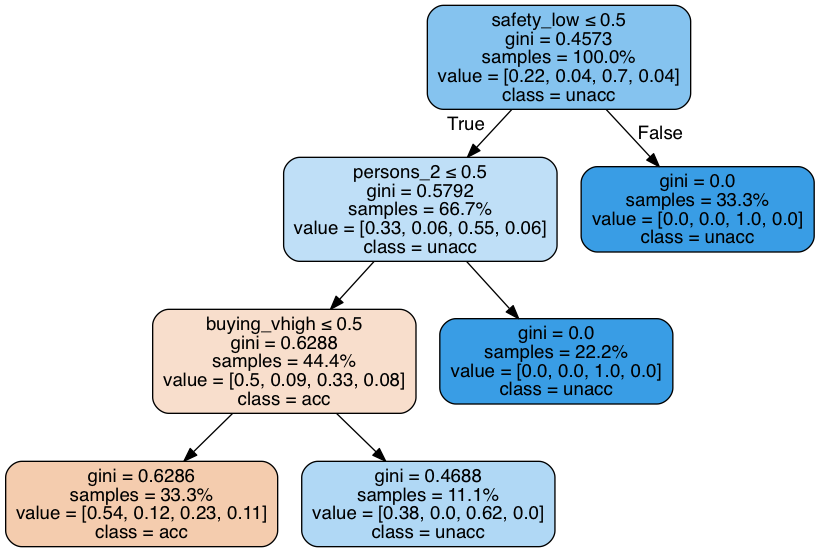

In [4]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data,  
                feature_names=X.columns,  
                class_names=le.classes_,  
                filled=True, rounded=True,
                proportion=True,
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

![image](./assets/images/output_17_0.png)

In [57]:
df[df['persons']=='2'].acceptability.value_counts()

unacc    576
Name: acceptability, dtype: int64

The first choice involves `person_2`. If the car only takes 2 people (`person_2` == 1) then the condition (our target class) is `unacceptable`. This happens in 33% of the cases. Note that the leaf under the `False` branch is 100% pure, and therefore its Gini measure is 0.0.

On the other hand, if the car can hold more than 2 people, we will need to consider other choices. For example if the car is unsafe, then it's also unacceptable. And so on.

> **Check:** What could be an advantage of using a decision tree in a model at work?

> Possible answer: easier to communicate results and understand relevant features.

If the target is a classification taking values 0, 1, ... K-2, K-1. If node $m$ represents a region $R_m$ with $N_m$ observations, the proportion of class $k$ observations in node $m$ can be written as:
$$
        C_k = \frac{1}{N_m} \sum_{y_m\text{ in }R_m} I(y_m = k)
$$


The Gini Index, measuring impurity,  is then defined as:
$$
        \text{Gini}= \sum_{k=0}^{K-1} C_k (1 - C_k)
$$

[This is](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) the sum of the probability of some class being chosen multiplied by the probability of an incorrect choice: it shows us how often you'd be wrong if you just guessed randomly from the classes in that sample, [conditional on some class being true](http://stats.stackexchange.com/questions/175087/basic-gini-impurity-derivation).

Thanks to summation rules, and the fact that the individual probabilities for all classes must sum to 1, we can rearrange this as:

$$
\sum_{k=0}^{K-1} (C_k - C_k^2) = \sum_{k=0}^{K-1} C_k - \sum_{k=0}^{K-1} C_k^2 = 1 - \sum_{k=0}^{K-1} C_k^2
$$

Let's plot the gini index for various proportions in a binary classification:

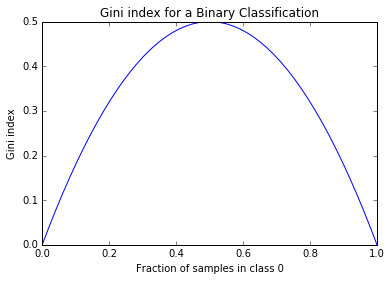

In [30]:
C0 = np.linspace(0,1)
C1 = 1.0 - C0

# Because it's binary, you can't do worse than .50
gini = 1 - (C0**2 + C1**2)

plt.plot(C0, gini)
plt.title('Gini index for a Binary Classification') 
plt.xlabel('Fraction of samples in class 0')
plt.ylabel('Gini index')

Let's verify the calculation of the Gini index in the root node of the tree above:

In [58]:
root_node_values = [0.22, 0.04, 0.7, 0.04]

def gini(values):
    tot = 0.0
    for val in values:
        tot += val ** 2
    
    return 1.0 - tot

gini(root_node_values)

0.45840000000000003

**Check:** Check that the value we obtained is the same as the one appearing in our decision tree.

Great, now we are ready to look at feature importances in our tree:

In [82]:
print X.columns
print dt.feature_importances_

Index([u'buying_high', u'buying_low', u'buying_med', u'buying_vhigh',
       u'maint_high', u'maint_low', u'maint_med', u'maint_vhigh', u'doors_2',
       u'doors_3', u'doors_4', u'doors_5more', u'persons_2', u'persons_4',
       u'persons_more', u'lug_boot_big', u'lug_boot_med', u'lug_boot_small',
       u'safety_high', u'safety_low', u'safety_med'],
      dtype='object')
[ 0.          0.          0.          0.09126812  0.          0.          0.
  0.          0.          0.          0.          0.          0.36349275
  0.          0.          0.          0.          0.          0.
  0.54523913  0.        ]


In [84]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head()

,importance
safety_low,0.545239
persons_2,0.363493
buying_vhigh,0.091268
buying_high,0.000000
doors_5more,0.000000


Since we artificially constricted the tree to be small, only 3 features are used to make splits. Let's verify the calculation of the importance.

In [85]:
gini_gain_persons_2  = 1.0 * 0.45728376  - 0.667 * 0.57923569 - 0.333 * 0.0
gini_gain_safety_low   = 0.666 * 0.57923569 - 0.444 * 0.62880113 - 0.222 * 0.0
gini_gain_buying_vhigh = 0.444 * 0.62880113 - 0.333 * 0.6285747 - 0.111 * 0.46875

# gini_gain_persons_2  = 1.0 * 0.45728376  - 0.667 * 0.57923569 - 0.333 * 0.0
# gini_gain_safety_low   = 0.666 * 0.57923569 - 0.444 * 0.62880113 - 0.222 * 0.0
# gini_gain_buying_vhigh = 0.444 * 0.62880113 - 0.333 * 0.6285747 - 0.111 * 0.46875

# Calc total decrease in node impurity, weighted by prob of reaching that node (i.e. % of samples there)

norm = gini_gain_persons_2 + gini_gain_safety_low + gini_gain_buying_vhigh

print "persons_2:", gini_gain_persons_2 / norm
print "safety_low:", gini_gain_safety_low / norm
print "buying_vhigh:", gini_gain_buying_vhigh / norm

persons_2: 0.363095401091
safety_low: 0.545579514578
buying_vhigh: 0.0913250843306


<a name="guided-practice"></a>
## Guided Practice: Feature importance in Ensemble models (25 min)

Scikit-learn [implements feature importance](http://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined) for random forest and extra trees methods.

Let's train one of each of these and investigate the feature importance:

- Random Forest
- Extra Trees

In [97]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)
et.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Random forest exposes the feature importance and it calculates it as the average feature importance of the trees.

In [88]:
importances = rf.feature_importances_
importances

array([ 0.04068273,  0.05860764,  0.03798336,  0.0328282 ,  0.06085139,
        0.04222598,  0.04304468,  0.06012899,  0.03703755,  0.01326065,
        0.01103502,  0.01305074,  0.09281878,  0.02200745,  0.0240969 ,
        0.04749043,  0.02993831,  0.07192759,  0.09826481,  0.09384095,
        0.06887785])

Let's compare the 3 models (re-init Decision Tree)

,dt_importance,rf_importance,et_importance
safety_low,0.155542,0.122713,0.094650
persons_2,0.233312,0.100690,0.089429
safety_med,0.031682,0.099308,0.071808
lug_boot_small,0.069452,0.065929,0.082197
buying_high,0.000000,0.063421,0.058072


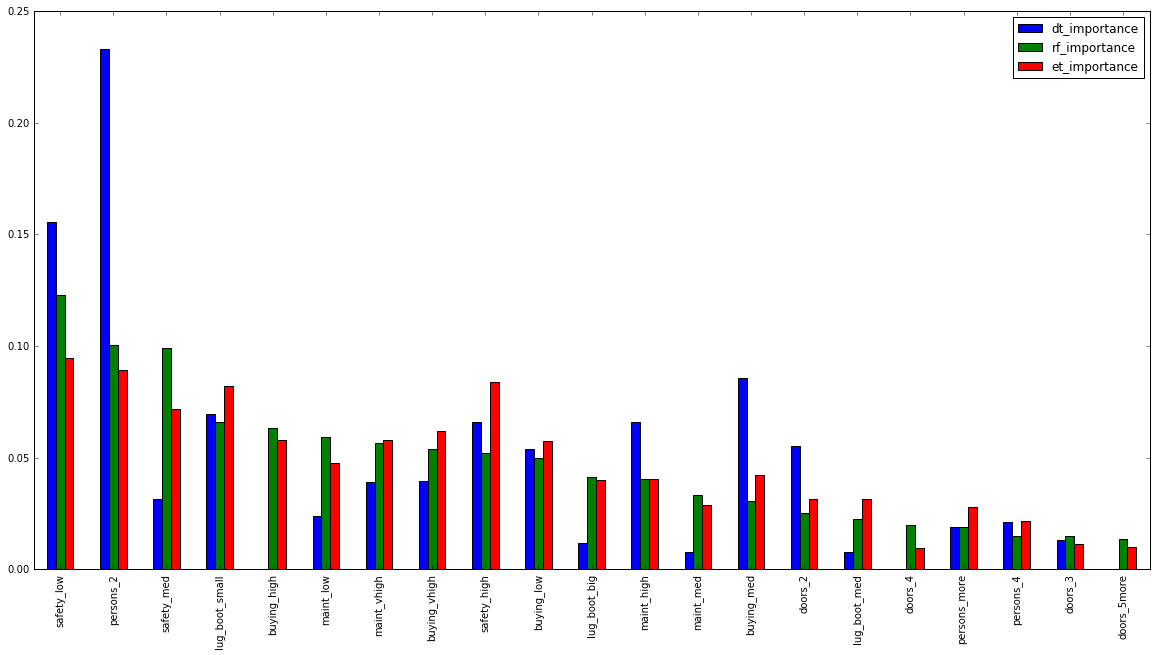

In [100]:
dt = DecisionTreeClassifier()
dt.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar')
importances.head()

**Check:** Discuss in your tables the plot above. What are the common things across all models? What are the differences?

<a name="conclusion"></a>
## Conclusion (5 min)

In this class we learned about feature importance and how they are calculated for tree based models.
We have also deepened our understanding of the Gini measure.

**Check:** How can you use this in practice?

### ADDITIONAL RESOURCES

- [Gini Importance](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp)
- [DT Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Feature Importance in Sklearn Blog](http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/)
- [Plot Feature Importances example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- [Selecting good features](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)